# 🍕 Pizza Sales Analysis – Business Insights

This notebook explores the sales data of a pizza restaurant to uncover key business insights and patterns. Using a combination of exploratory data analysis (EDA), time-based breakdowns, and visualizations, we aim to understand how various factors such as day of the week, time of day, pizza type, and ingredients influence overall performance.

The analysis is structured to answer the following questions:
1. When is the restaurant busiest — across days, weeks, and hours?
2. What are the top-performing pizzas in terms of volume and revenue?
3. Are there any seasonal or weekly trends worth noting?

We conclude with practical, data-driven recommendations to support business decisions around marketing, product offering, and operations.

In [14]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
order_details = pd.read_parquet(data_path + 'order_details.parquet')
orders = pd.read_parquet(data_path + 'orders.parquet')
pizza_types = pd.read_csv(data_path + 'pizza_types.csv', encoding='latin1')  # encoding
pizzas = pd.read_csv(data_path + 'pizzas.csv')

# Merge all data into a single DataFrame
df = (
    order_details
    .merge(pizzas, on='pizza_id', how='left')
    .merge(pizza_types, on='pizza_type_id', how='left')
    .merge(orders, on='order_id', how='left')
)

# Feature engineering
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')
df['dow'] = df['date'].dt.day_name()
df['revenue'] = df['price'] * df['quantity']

# Preview the final dataset
df.head()

,order_details_id,order_id,pizza_id,quantity,pizza_type_id,size,price,name,category,ingredients,date,time,week_start,month_start,wday,hour,month,dow,revenue
0,1,1,hawaiian_m,1,hawaiian,M,13.25,The Hawaiian Pizza,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",2015-01-01,11:38:36,2014-12-29,2015-01-01,3,11.633333,2015-01,Thursday,13.25
1,2,2,classic_dlx_m,1,classic_dlx,M,16.00,The Classic Deluxe Pizza,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",2015-01-01,11:57:40,2014-12-29,2015-01-01,3,11.950000,2015-01,Thursday,16.00
2,3,2,five_cheese_l,1,five_cheese,L,18.50,The Five Cheese Pizza,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",2015-01-01,11:57:40,2014-12-29,2015-01-01,3,11.950000,2015-01,Thursday,18.50
3,4,2,ital_supr_l,1,ital_supr,L,20.75,The Italian Supreme Pizza,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",2015-01-01,11:57:40,2014-12-29,2015-01-01,3,11.950000,2015-01,Thursday,20.75
4,5,2,mexicana_m,1,mexicana,M,16.00,The Mexicana Pizza,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",2015-01-01,11:57:40,2014-12-29,2015-01-01,3,11.950000,2015-01,Thursday,16.00


In [15]:
# Sanity Check & Data Quality Control

print("Null Values Check:")
print(df.isnull().sum())

print("\nDuplicate Rows Check:")
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

print("\nPrice Value Range Check:")
print(f"Min Price: {df['price'].min()}")
print(f"Max Price: {df['price'].max()}")

print("\nZero Revenue Rows (Should be 0):")
zero_revenue_rows = df[df['revenue'] == 0]
print(f"Rows with zero revenue: {len(zero_revenue_rows)}")

print("\nOrder ID Integrity Check (Missing Order IDs):")
missing_orders = set(range(df['order_id'].min(), df['order_id'].max() + 1)) - set(df['order_id'].unique())
print(f"Missing Order IDs (if any): {missing_orders if missing_orders else 'None'}")

print("\n✅ Sanity Check Completed")

Null Values Check:
order_details_id    0
order_id            0
pizza_id            0
quantity            0
pizza_type_id       0
size                0
price               0
name                0
category            0
ingredients         0
date                0
time                0
week_start          0
month_start         0
wday                0
hour                0
month               0
dow                 0
revenue             0
dtype: int64

Duplicate Rows Check:
Number of duplicate rows: 0

Price Value Range Check:
Min Price: 9.75
Max Price: 35.95

Zero Revenue Rows (Should be 0):
Rows with zero revenue: 0

Order ID Integrity Check (Missing Order IDs):
Missing Order IDs (if any): None

✅ Sanity Check Completed


In [16]:
print("Basic Input Tables Stats\n")

# ORDERS
print(" ORDERS:")
print(f"Total rows: {len(orders)}")
print(f"Order date range: {orders['date'].min().date()} → {orders['date'].max().date()}")
print(f"Earliest order time: {orders['time'].min()} | Latest: {orders['time'].max()}")
print(f"Unique weekdays (wday): {np.sort(orders['wday'].unique())}")
print(f"Number of unique days in dataset: {orders['date'].nunique()} / 365")
print()

# ORDER_DETAILS
print(" ORDER_DETAILS:")
print(f"Total rows: {len(order_details)}")
print(f"Unique order IDs: {order_details['order_id'].nunique()}")
print(f"Unique pizza IDs: {order_details['pizza_id'].nunique()}")
print(f"Quantity range: {order_details['quantity'].min()} → {order_details['quantity'].max()}")
print()

# PIZZAS
print(" PIZZAS:")
print(f"Total pizzas (variants): {len(pizzas)}")
print(f"Unique pizza types: {pizzas['pizza_type_id'].nunique()}")
print(f"Available sizes: {pizzas['size'].unique().tolist()}")
print(f"Price range: ${pizzas['price'].min():.2f} → ${pizzas['price'].max():.2f}")
print()

# PIZZA_TYPES
print(" PIZZA_TYPES:")
print(f"Total types: {len(pizza_types)}")
print(f"Categories: {pizza_types['category'].unique().tolist()}")
print(f"Longest ingredient list: {pizza_types['ingredients'].map(lambda x: len(x.split(','))).max()} ingredients")

Basic Input Tables Stats

 ORDERS:
Total rows: 21350
Order date range: 2015-01-01 → 2015-12-31
Earliest order time: 09:52:21 | Latest: 23:05:52
Unique weekdays (wday): [0 1 2 3 4 5 6]
Number of unique days in dataset: 358 / 365

 ORDER_DETAILS:
Total rows: 48620
Unique order IDs: 21350
Unique pizza IDs: 91
Quantity range: 1 → 4

 PIZZAS:
Total pizzas (variants): 96
Unique pizza types: 32
Available sizes: ['S', 'M', 'L', 'XL', 'XXL']
Price range: $9.75 → $35.95

 PIZZA_TYPES:
Total types: 32
Categories: ['Chicken', 'Classic', 'Supreme', 'Veggie']
Longest ingredient list: 8 ingredients


In [17]:
# Basic statistics

# Compute total number of pizzas sold and total revenue generated 
total_pizzas_sold = df['quantity'].sum()
total_revenue = df['revenue'].sum().round()

# Compute Average Order Value
order_revenue = df.groupby('order_id', as_index=False)['revenue'].sum()
average_order_value = round(order_revenue['revenue'].mean(), 2)

# Compute Average Items per Order
average_items_per_order = round(df.groupby('order_id')['quantity'].sum().mean(), 2)

# Number of unique orders
total_orders = df['order_id'].nunique()

# Identify the top 6 best-selling pizzas share (by quantity sold)
top_pizzas = (
    df.groupby('name', as_index=False)['quantity']
    .sum()
    .sort_values('quantity', ascending=False)
)

top_6_pizzas_units = top_pizzas.head(6)['quantity'].sum()
top_6_share_percentage = round((top_6_pizzas_units / total_pizzas_sold) * 100, 2)

# Print Headline KPIs
print(f"Total Pizzas Sold: {total_pizzas_sold}")
print(f"Total Revenue:  ${total_revenue}") # Dollars assumed
print(f"Total Orders: {total_orders}")
print(f"AOV (Average Order Value): {average_order_value}")
print(f"Average Items per Order: {average_items_per_order}")
print(f"Top 6 Pizzas = {top_6_share_percentage}% of total sales")

Total Pizzas Sold: 49574
Total Revenue:  $817860.0
Total Orders: 21350
AOV (Average Order Value): 38.31
Average Items per Order: 2.32
Top 6 Pizzas = 29.18% of total sales


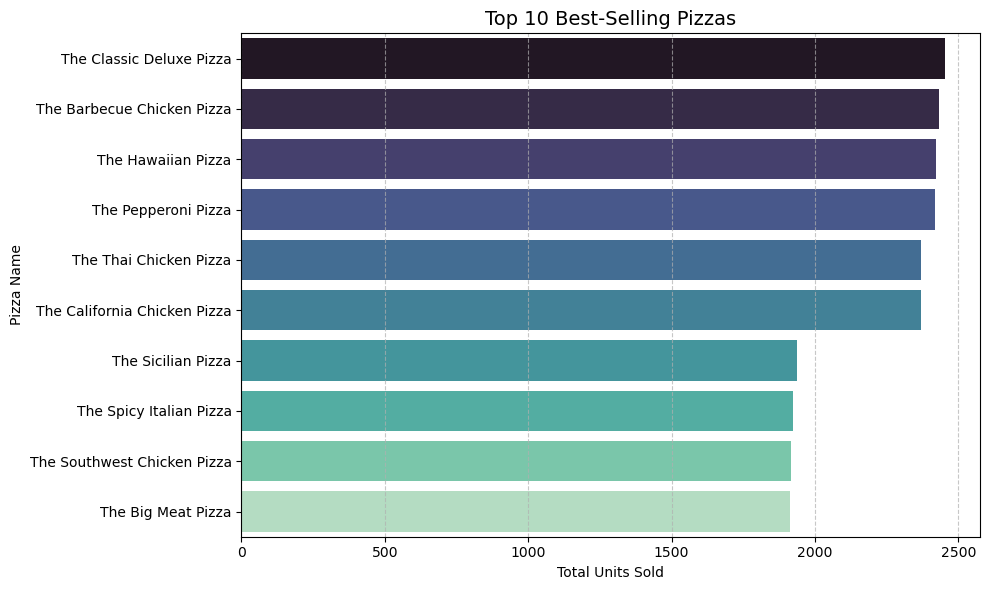

In [18]:
# Top 10 best-selling pizzas

# Aggregate total quantity sold per pizza type
top_pizza = (
    df.groupby('name', as_index=False)['quantity']
    .sum()
    .sort_values('quantity', ascending=False)
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_pizza.head(10), y='name', x='quantity', palette='mako')
plt.title('Top 10 Best-Selling Pizzas', fontsize=14)
plt.xlabel('Total Units Sold')
plt.ylabel('Pizza Name')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

1. The chart displays the top 10 best-selling pizza types based on total units sold across the entire dataset.
2. The Classic Deluxe, Barbecue Chicken, and Hawaiian pizzas clearly lead the rankings, while the top 6 pizzas combined account for a significant portion of total sales — an indication of a strong concentration in customer preferences.

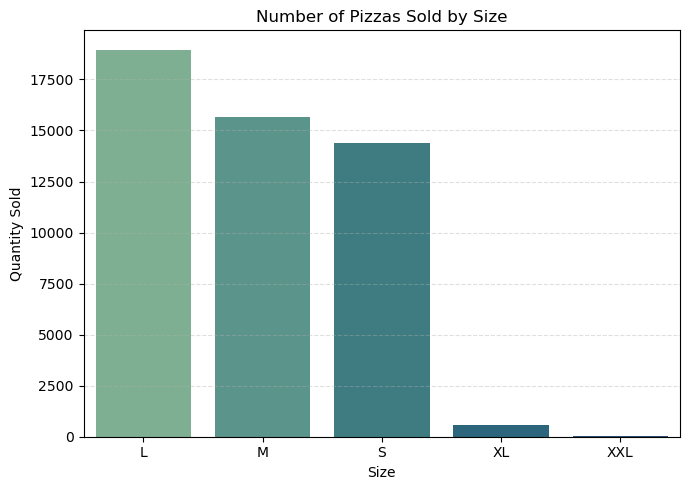

In [19]:
# Size distribution of sold pizzas

# Verifying dataset consistency: size information extracted from the 'pizza_id' string
# matches the 'size' column perfectly, confirming data reliability.

# Aggregate total quantity sold per size
size_distribution = (
    df.groupby('size')['quantity']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Plot
plt.figure(figsize=(7, 5))
sns.barplot(data=size_distribution, x='size', y='quantity', palette='crest')
plt.title('Number of Pizzas Sold by Size')
plt.xlabel('Size') 
plt.ylabel('Quantity Sold')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

1. The chart illustrates the total number of pizzas sold by size. Sizes L, M, and S dominate sales, with L being the most popular.
2. Although XL and XXL sizes appear to underperform, it's important to note that they are only available for one pizza type (Greek Style Pizza), which explains their low sales volume.

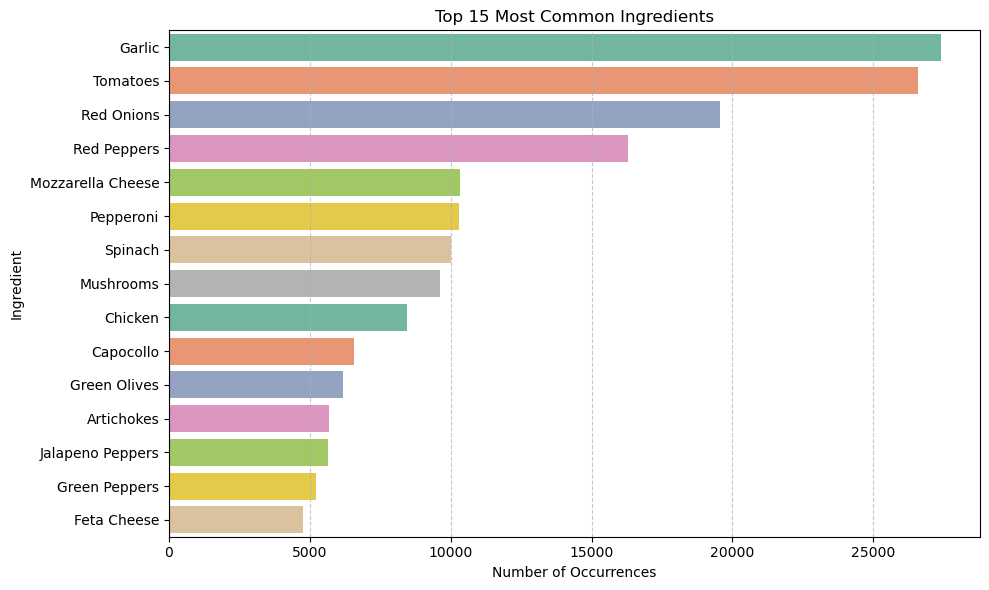

In [20]:
# Top ingredients by frequency across all pizza types

# Extract and count individual ingredients
ingredients_series = df.loc[df['ingredients'].notna(), 'ingredients'].str.split(', ')
ingredients_exploded = ingredients_series.explode()
ingredients_counts = (
    ingredients_exploded.value_counts()
    .reset_index()
    .rename(columns={'index': 'ingredient', 'ingredients': 'count'})
)

# Plot the 15 most common ingredients
plt.figure(figsize=(10, 6))
sns.barplot(data=ingredients_counts.head(15), x='count', y='ingredient', palette='Set2')
plt.title('Top 15 Most Common Ingredients')
plt.xlabel('Number of Occurrences')
plt.ylabel('Ingredient')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

1. The most common ingredients are garlic, tomatoes, and red onions — each appearing in over 19,000 pizza entries.
2. The top 4 ingredients are widely used across the menu, indicating potential for streamlining inventory and supply chain processes.

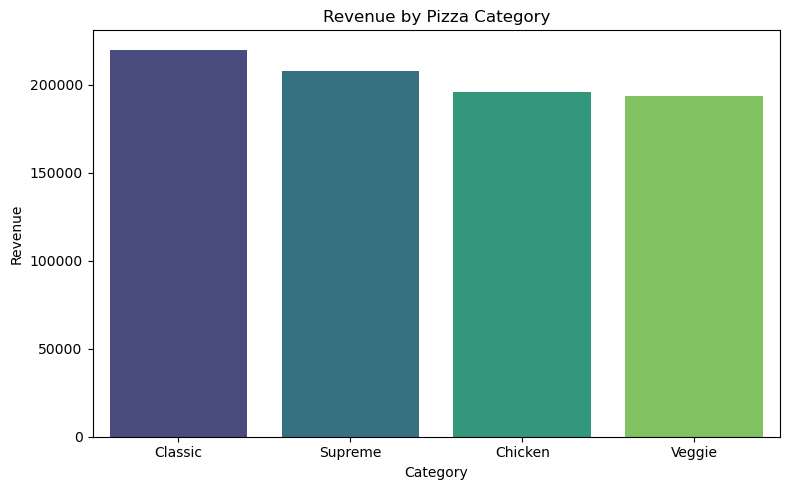

In [21]:
# Revenue per category

# Aggregate total revenue per pizza category
category_revenue = (
    df.groupby('category')['revenue']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=category_revenue, x='category', y='revenue', palette='viridis')
plt.title('Revenue by Pizza Category')
plt.xlabel('Category')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()

1. The Classic category generated the highest revenue at approximately 220,000, slightly ahead of Supreme at around 208,000.
2. The revenue gap between all four categories is relatively small (~30,000 between top and bottom), suggesting a well-balanced menu performance across styles.

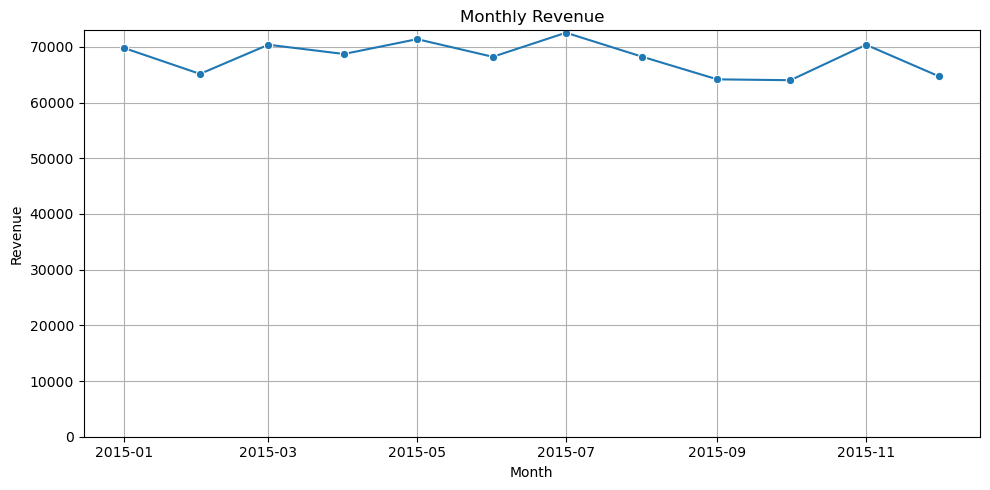

In [22]:
# Monthly revenue

# Aggregate total revenue per month
monthly_revenue = (
    df.groupby(df['date'].dt.to_period('M'))['revenue']
    .sum()
    .reset_index()
)

monthly_revenue['date'] = monthly_revenue['date'].dt.to_timestamp()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_revenue, x='date', y='revenue', marker='o')
plt.title('Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True)
plt.tight_layout()

# Force y-axis to start at 0 to avoid misleading visual exaggeration of variation
plt.ylim(bottom=0)

plt.show()

1. Monthly revenue remains relatively stable throughout the year, fluctuating between aprox. $64,000 and %72,000 
2. Setting the y-axis baseline to zero helps avoid overstating the month-to-month variations, which in reality are not significant.

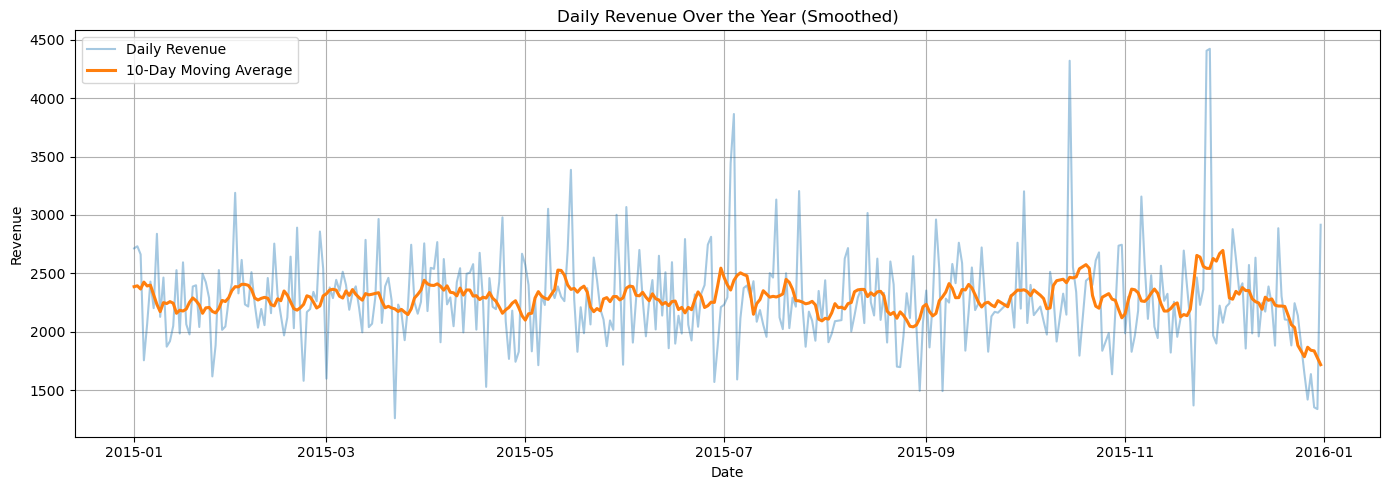

In [28]:
# Daily revenue with smoothing

daily_revenue = df.groupby('date')['revenue'].sum().reset_index()

# Calculate 10-day moving average
daily_revenue['revenue_smooth'] = daily_revenue['revenue'].rolling(window=10, min_periods=1, center=True).mean()

plt.figure(figsize=(14, 5))
sns.lineplot(data=daily_revenue, x='date', y='revenue', label='Daily Revenue', alpha=0.4)
sns.lineplot(data=daily_revenue, x='date', y='revenue_smooth', label='10-Day Moving Average', linewidth=2.2)

plt.title('Daily Revenue Over the Year (Smoothed)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


1. Daily revenue shows considerable variability, with frequent short-term spikes and dips throughout the year.  
2. The 10-day moving average highlights a more stable underlying trend, smoothing out noise and revealing consistent performance with a slight downward shift toward the end of the year.

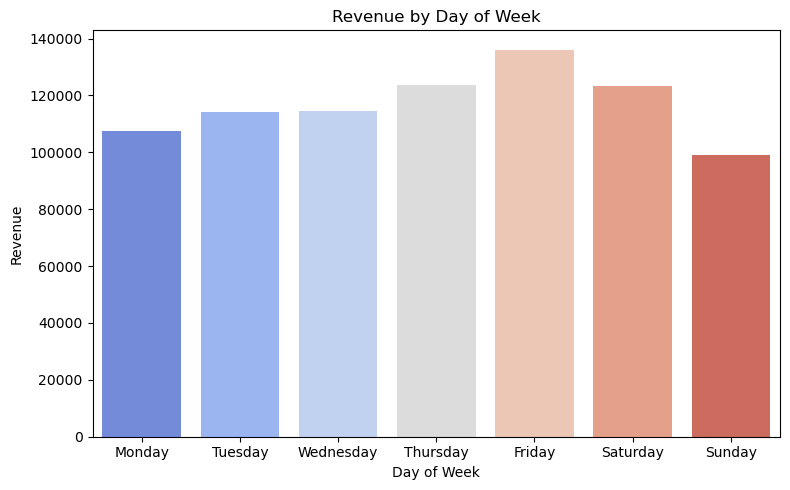

In [24]:
# Revenue by day of the week

# Ordering DOWs 
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['dow'] = pd.Categorical(df['dow'], categories=dow_order, ordered=True)

dow_revenue = (
    df.groupby('dow')['revenue']
    .sum()
    .reset_index()
)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=dow_revenue, x='dow', y='revenue', palette='coolwarm')
plt.title('Revenue by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()

1. The highest revenue is observed on Friday, followed by Saturday and Thursday.
2. Sunday generates the least revenue.
3. Weekdays (Monday–Thursday) maintain relatively consistent revenue levels, with a notable increase starting Thursday.

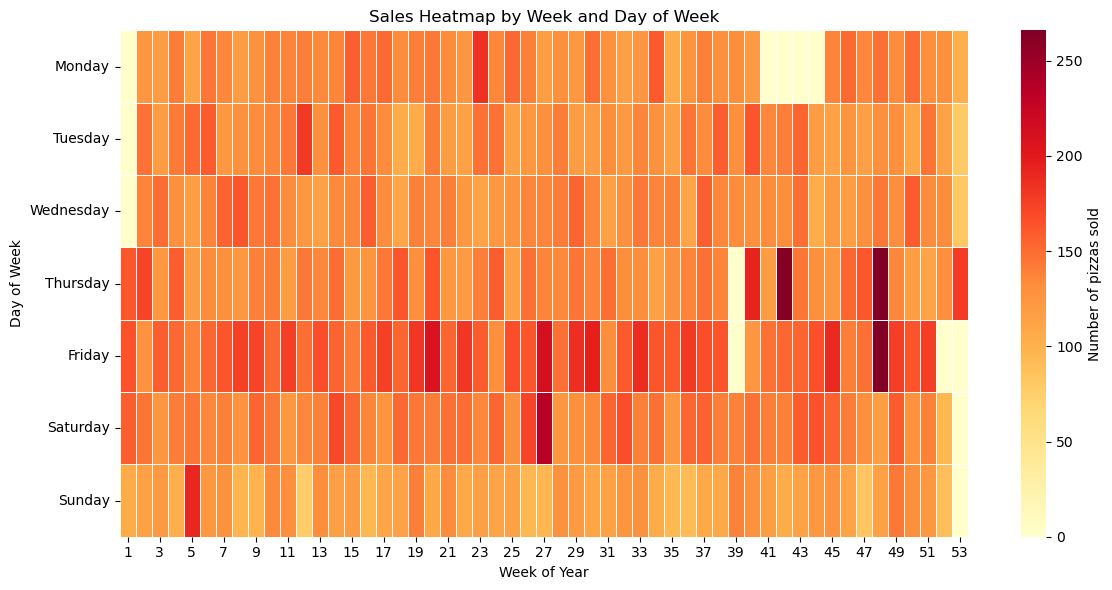

In [25]:
# Sales heatmap by week and day of week

heatmap_data = (
    df.groupby(['dow', df['date'].dt.isocalendar().week])['quantity']
    .sum()
    .unstack(level=0)
    .fillna(0)
)

# Reorder days of the week
heatmap_data = heatmap_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data.T,
    cmap='YlOrRd',
    linewidths=0.5,
    cbar_kws={'label': 'Number of pizzas sold'}
)
plt.title('Sales Heatmap by Week and Day of Week')
plt.xlabel('Week of Year')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

1. Fridays show the highest sales volumes throughout the year.
2. Overall, sales appear relatively stable across the weeks, with only slight fluctuations.
3. Sales are generally lower at the start and end of the year.

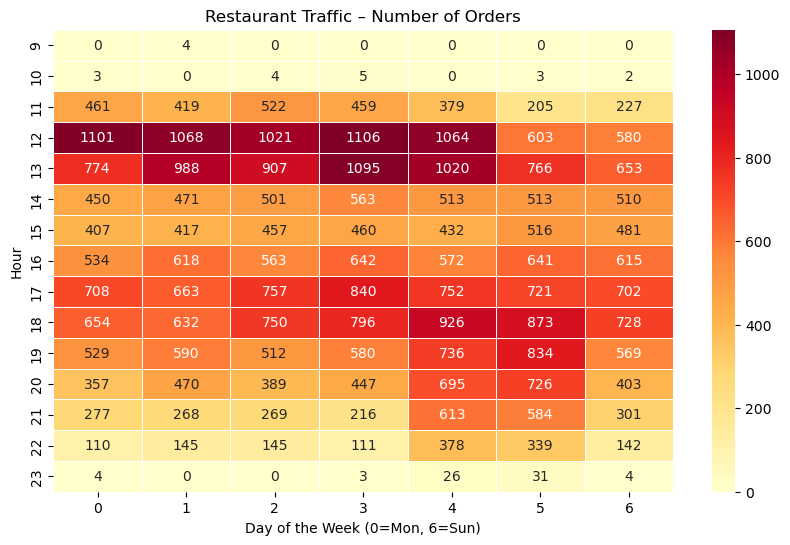

In [26]:
# Most insightful plot: shows hourly traffic across days of the week

# Formatting hour 
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour

heatmap_data = df.pivot_table(
    index='hour',       # rows: hours
    columns='wday',     # columns: days of the week (0=Mon, 6=Sun)
    values='order_id',  # what we're counting
    aggfunc='count',    # number of orders
    fill_value=0        # if no orders, fill with 0
)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, 
            cmap='YlOrRd', 
            linewidths=0.5, 
            annot=True, 
            fmt='d'
)
plt.xlabel("Day of the Week (0=Mon, 6=Sun)")
plt.ylabel("Hour")
plt.title("Restaurant Traffic – Number of Orders")
plt.show()

1. Restaurant traffic peaks consistently around lunch (12:00–14:00) and dinner time (17:00–19:00).
2. Traffic remains relatively stable across weekdays, with Friday and Saturday slightly busier in the evening.
3. There is almost no customer activity before 11:00 AM or after 10:00 PM.
4. These trends suggest strong lunchtime and evening demand, which could inform staffing and promo timing.

## 📊 Summary Insights & Business Recommendations

### 🔍 Key Insights:
- There are no significant peaks across the weeks of the year, apart from a typical dip around the end/beginning of the year likely due to reduced traffic and temporary closures.
- Daily sales are fairly balanced throughout the week, with Friday peak and a slight drop on Sundays — a common industry pattern.
- The top 6 pizzas contribute to almost 30% of total sales volume.
- Large pizzas are most commonly sold, XL and XXL have high price and low demand.
- Garlic, Tomatoes, Red Onions, Red Peppers	are the most common ingredients.
- DOW/time traffic heatmap indicates that the restaurant is likely located in a mixed-use business and residential area. This conclusion is based on two clear traffic patterns:
  - A strong lunch peak between 12:00–13:00 on weekdays, suggesting high demand from nearby office workers or business employees.
  - Increased evening activity on Fridays and Saturdays (17:00–21:00), which typically reflects leisure traffic from individual or group diners.

### 💡 Recommendations:
- Focus marketing on the top 6 bestselling pizzas with higher margins.
- Introduce combo offers or promotions targeting Sundays.
- If the high unit price of XL/XXL sizes justifies their preparation costs, consider offering them for more pizza types to increase reach. Otherwise, phase them out to optimize inventory and prep time.
- Use popular ingredients to design new high-margin signature pizzas.
